In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from glob import glob
from tqdm import tqdm
import xarray as xr
import os, sys
import scipy
import pandas as pd
from scipy.ndimage import gaussian_filter
from sklearn.decomposition import PCA
from scipy import stats
from scipy import interpolate
from glob import glob

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

from utils import *

In [3]:
# for plotting
plt.rcParams.update({'font.size': 16})

In [4]:
exp_meta_data_dir = '../meta_data/exp'
exp_data_dir = '../processed_data/exp'
sim_data_dir = '../processed_data/sim'

fig_dir = 'Figures/Figure_6'

# Load data from experiments

In [5]:
# Load meta data
manifest_path = os.path.join(exp_meta_data_dir, 'ecephys_cache_dir_10_31', "manifest.json")
#manifest_path = os.path.join(exp_meta_data_dir, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

## LFP and CSD

In [6]:
channels = cache.get_channels()
probes = cache.get_probes()

In [7]:
trial_window_start = -1.0
trial_window_end = 0.5


loadpaths_csd = sorted(glob(os.path.join(exp_data_dir, 'csd', 
            'trial_window_'+str(trial_window_start).replace('.','pnt')+\
             '_to_'+str(trial_window_end).replace('.','pnt')+'s', '*')))
loadpaths_lfp = sorted(glob(os.path.join(exp_data_dir, 'lfp', 'trial_window_'\
             +str(trial_window_start).replace('.','pnt')+\
             '_to_'+str(trial_window_end).replace('.','pnt')+'s', '*')))
    
len(loadpaths_csd)

53

In [8]:
twoi_start = -0.0
twoi_end = 0.1

Fs = 1250 # Hz

In [9]:
twoi_start = -0.0
twoi_end = 0.1

Fs = 1250 # Hz

session_ids = list() # all session ids
sessions_channels_vert_pos = dict()
sessions_csd_trial_avg = dict()
sessions_csd_all_trials = dict()
sessions_channel_ids_csd = dict()

for i, file_path in enumerate(loadpaths_csd):
    session_id = os.path.basename(file_path).split('_')[0]
    print('Session id: ', session_id)
    data = np.load(file_path, allow_pickle = True)
        
    session_ids.append(session_id)
        
    t = np.array(data[()]['csd_mean']['time_from_presentation_onset'])
    t_min = twoi_start; t_max = twoi_end
    mask = np.logical_and(t>=t_min, t<=t_max)
    t = t[mask]
    
    channels_vert_pos = data[()]['channel_vertical_pos']
    channels_vert_pos = channels_vert_pos[::-1]
    channels_vert_pos -= channels_vert_pos.max()
    sessions_channels_vert_pos[session_id] = channels_vert_pos
    
    mask_session = channels['ecephys_session_id'] == int(session_id)
    mask_structure = channels[mask_session]['ecephys_structure_acronym'] == 'VISp'
    dorsal_ventral_ccf_coordinate = channels[mask_session][mask_structure]['dorsal_ventral_ccf_coordinate']
    channel_ids_csd = data[()]['csd_mean'].channel.values
    dorsal_ventral_ccf_coordinate = -(dorsal_ventral_ccf_coordinate[channel_ids_csd]-dorsal_ventral_ccf_coordinate[channel_ids_csd].min())# higher dorsal-ventral value means more ventral
    
    if ~np.all(np.isnan(dorsal_ventral_ccf_coordinate)): # if all NaNs it means exact probe location not recovered
        csd_trial_avg = data[()]['csd_mean']
        csd_trial_avg = csd_trial_avg[:,mask]
        sessions_csd_trial_avg[session_id] = csd_trial_avg.values

        csd_all_trials = data[()]['csd']
        csd_all_trials = csd_all_trials[:,:,mask]
        sessions_csd_all_trials[session_id] = csd_all_trials.values
        
        sessions_channel_ids_csd[session_id] = channel_ids_csd

Session id:  715093703
Session id:  719161530
Session id:  721123822
Session id:  732592105
Session id:  737581020
Session id:  739448407
Session id:  742951821
Session id:  744228101
Session id:  746083955
Session id:  750332458
Session id:  750749662
Session id:  751348571
Session id:  754312389
Session id:  754829445
Session id:  755434585
Session id:  756029989
Session id:  757216464
Session id:  757970808
Session id:  758798717
Session id:  759883607
Session id:  760345702
Session id:  760693773
Session id:  761418226
Session id:  762120172
Session id:  762602078
Session id:  763673393
Session id:  766640955
Session id:  767871931
Session id:  768515987
Session id:  771160300
Session id:  771990200
Session id:  773418906
Session id:  774875821
Session id:  778240327
Session id:  778998620
Session id:  779839471
Session id:  781842082
Session id:  786091066
Session id:  787025148
Session id:  789848216
Session id:  791319847
Session id:  793224716
Session id:  794812542
Session id:

### Load channel depth data

In [10]:
#filename = 'cortical_depth_'+str(session_id)+'.csv'
#loadpath = os.path.join(exp_meta_data_dir, 'probes_cortical_depths', filename)
sessions_df_depth = dict()
loadpaths = sorted(glob(os.path.join(exp_meta_data_dir, 'probes_cortical_depths', '*')))
for loadpath in loadpaths:
    session_id = loadpath.split('/')[-1].split('.')[0].split('_')[-1]
    df_depth = pd.read_csv(loadpath, sep=' ')
    df_depth = df_depth.set_index('id')
    sessions_df_depth[session_id] = df_depth

#### Remove faulty channels

In [11]:
structure = 'VISp'
sessions_channels_cort_depth = dict()

for session_id in sessions_df_depth.keys():
    df_depth = sessions_df_depth[session_id]
    mask_structure = df_depth.ecephys_structure_acronym == structure
    df_depth = df_depth[mask_structure]
    channels_cort_depth = df_depth.cortical_depth
        
    if session_id in sessions_channel_ids_csd.keys():
        print('Session ID: ', session_id)
        
        channel_ids_csd = sessions_channel_ids_csd[session_id]
    
        channels_cort_depth = channels_cort_depth[channel_ids_csd]      
        sessions_channels_cort_depth[session_id] = channels_cort_depth.values
        
print('\n ---------------------------------------------- \n')
sessions_channels_cort_depth_cleaned = dict()
for session_id, channels_cort_depth in sessions_channels_cort_depth.items():
    channels_cort_depth = channels_cort_depth[::-1]
    
    mask_nan = np.isnan(channels_cort_depth)
    
    channels_cort_depth_no_nan = channels_cort_depth[~mask_nan][::-1]
    
    if mask_nan.sum() > 0:
        print('Session ID: ', session_id, 'has NaN channels', channels_cort_depth, '\n', channels_cort_depth_no_nan, '\n', len(channels_cort_depth_no_nan))
        
    mask_zeros_after_1st_chan = channels_cort_depth_no_nan == 0
    
    if mask_zeros_after_1st_chan[1:].sum() > 0:
        end_chan = np.where(mask_zeros_after_1st_chan[1:])[0][0]+1

        channels_cort_depth_cleaned = channels_cort_depth_no_nan[:end_chan]

        print('Session ID: ', session_id, 'has channels outside cortex. Removed.', \
              channels_cort_depth_no_nan, '\n', channels_cort_depth_cleaned, len(channels_cort_depth_cleaned))
    
        sessions_channels_cort_depth_cleaned[session_id] = channels_cort_depth_cleaned
    else:
        sessions_channels_cort_depth_cleaned[session_id] = channels_cort_depth_no_nan
        
sessions_csd_trial_avg_short = dict()
sessions_csd_all_trials_short = dict()
for isess, session_id in enumerate(sessions_csd_trial_avg.keys()):
    csd_trial_avg = sessions_csd_trial_avg[session_id]
    csd_all_trials = sessions_csd_all_trials[session_id]
    
    channels_vert_pos = sessions_channels_vert_pos[session_id]
    
    cut_off_chan = len(sessions_channels_cort_depth_cleaned[session_id])
    
    #print(isess, session_id, csd_trial_avg.shape[0], channels_vert_pos[-1], \
    #      channels_vert_pos[:cut_off_chan].shape, channels_vert_pos[:cut_off_chan][-1])#,\

    sessions_csd_trial_avg_short[session_id] = csd_trial_avg[:cut_off_chan]
    sessions_csd_all_trials_short[session_id] = csd_all_trials[:cut_off_chan]

Session ID:  715093703
Session ID:  719161530
Session ID:  721123822
Session ID:  744228101
Session ID:  750749662
Session ID:  751348571
Session ID:  754312389
Session ID:  754829445
Session ID:  755434585
Session ID:  756029989
Session ID:  757216464
Session ID:  757970808
Session ID:  758798717
Session ID:  759883607
Session ID:  760345702
Session ID:  761418226
Session ID:  762602078
Session ID:  763673393
Session ID:  766640955
Session ID:  767871931
Session ID:  768515987
Session ID:  771160300
Session ID:  771990200
Session ID:  773418906
Session ID:  774875821
Session ID:  778240327
Session ID:  778998620
Session ID:  779839471
Session ID:  781842082
Session ID:  786091066
Session ID:  787025148
Session ID:  789848216
Session ID:  791319847
Session ID:  793224716
Session ID:  794812542
Session ID:  797828357
Session ID:  798911424
Session ID:  799864342
Session ID:  816200189
Session ID:  829720705
Session ID:  831882777
Session ID:  835479236
Session ID:  839068429
Session ID:

## Load spike trains

In [12]:
exp_spike_data_dir = os.path.join(exp_data_dir, 'spikes', 'V1')
filename = 'sessions_spike_counts_-1to0pnt5s_white_flash.npy'

loadpath = os.path.join(exp_spike_data_dir, filename)

sessions_spike_trains_V1 = np.load(loadpath, allow_pickle = True)[()]

#### Load meta data

In [13]:
units = cache.get_units()

## Load simulation data

In [14]:
selected_sims_data_dir = os.path.join(sim_data_dir, 'model_versions')

In [15]:
nchan_sim = 23           # Number of channels on probe in simulation

trial_dur_sim = 750      # Duration one trial (ms)
tstim_onset_sim = 250    # Stimulus onset in each trial (ms)
ntrials_sim = 10         # Number of trials

### CSD

#### Total CSD

In [16]:
csd_sims = find_files(selected_sims_data_dir, filename = 'csd_total.npy')

print('Total CSD from model versions: ', list(csd_sims.keys()))

old_model
intermediate_model
final_model
Total CSD from model versions:  ['old_model', 'intermediate_model', 'final_model']


#### Population contributions to the CSD

In [17]:
csd_sims_layerpops = find_files(selected_sims_data_dir, filename = 'csd_layerpop_contributions_summed.npy')

for sim_name in list(csd_sims_layerpops.keys()):
    if 'final' not in sim_name:
        del csd_sims_layerpops[sim_name]

print('Population CSD from model versions', list(csd_sims_layerpops.keys()))

old_model
intermediate_model
final_model
Population CSD from model versions ['final_model']


## Spikes

In [18]:
def find_all_fir_rates_files_sim(path,filename):
    
    result = dict()
    for root, dirs, files in os.walk(path):
        if len(glob(os.path.join(root,filename)))>0:
            
            fir_rate_file_path = glob(os.path.join(root,filename))[0]
            sim_name = fir_rate_file_path.split('/')[-2]
            fir_rate_file = np.load(fir_rate_file_path, allow_pickle=True)[()]
            result[sim_name] = fir_rate_file
    return result

In [19]:
selected_sims_data_dir = os.path.join(sim_data_dir, 'model_versions')
timestamps_configs = find_all_fir_rates_files_sim(selected_sims_data_dir, 'timestamps_with_neuron_ids.npy')
sim_names = list(timestamps_configs.keys())
print(sim_names)
sim_name = sim_names[-1]

['old_model', 'intermediate_model', 'final_model']


# Make figures

### Sim CSD

In [20]:

step_depth_ticks_sim = 5
step_depth_ticklabels_sim = 200
#nchan_sim = csd_sims[list(csd_sims.keys())[0]]['trial_avg'].shape[0]
nchan_sim = 23
if nchan_sim == 51:
    nchan_sim = int(csd_sims[list(csd_sims.keys())[0]][()]['trial_avg'].shape[0]/2)+1
depth_ticks_sim = np.arange(0, nchan_sim, step_depth_ticks_sim)
depth_ticklabels_sim = -np.arange(0, 1000, step_depth_ticklabels_sim, dtype = 'int')

step_time_ticks_sim = 20
time_tick_stop_sim = 100
time_tick_start_sim = 0
time_ticks_sim = np.arange(time_tick_start_sim, time_tick_stop_sim+step_time_ticks_sim, step_time_ticks_sim)
time_ticklabels_sim = np.arange(time_tick_start_sim, time_tick_stop_sim+step_time_ticks_sim, step_time_ticks_sim)

In [21]:
sims_labels = dict()

sims_labels['old_model'] = 'Original model'
sims_labels['intermediate_model'] = 'Model w/adjusted\n syn. weights'
sims_labels['final_model'] = 'Final model \nw/feedback and LGN'

sims_colors = dict()
sims_colors['old_model'] = 'b'
sims_colors['intermediate_model'] = 'g'
sims_colors['final_model'] = 'tab:orange'

In [22]:
list(csd_sims.keys())[-1]

'final_model'

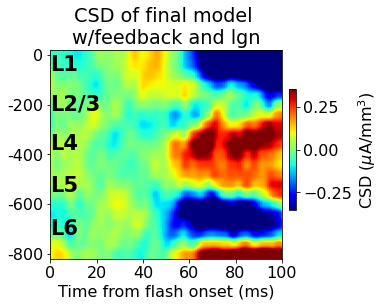

In [23]:
scale_to_uA = 1E-3

fig, ax = plt.subplots(1,1, figsize = (5.1,4.2))

fig.subplots_adjust(hspace = 0.4, wspace = 0.1, left = 0.12, right = 0.75, top = 0.83, bottom = 0.14)

sim_name = 'final_model'
        
csd_sim = csd_sims[sim_name]
csd_plot = csd_sim['trial_avg'][:nchan_sim-2,tstim_onset_sim:tstim_onset_sim+101]*scale_to_uA

ax.set_yticks(depth_ticks_sim)

ax.set_yticklabels(depth_ticklabels_sim)
#ax.set_ylabel('Depth ($\mu$m)')
cmap_range = np.abs(csd_plot).max()/2.4

im = ax.imshow(csd_plot, cmap = 'jet', aspect = 'auto', vmin = -cmap_range, vmax = cmap_range)

ax.set_xticks(time_ticks_sim)
ax.set_xticklabels(time_ticklabels_sim)
#ax.set_xlabel('Time from flash onset (ms)')

ax.set_xlim([0,100])


title = sims_labels[sim_name]
ax.set_title('CSD of '+title.lower())

cbaxes = fig.add_axes([0.77, 0.3, 0.02, 0.4])
cb = fig.colorbar(im, ax = ax, cax = cbaxes)
cb.set_label('CSD ($\mu$A/mm$^3$)')

plt.figtext(x = 0.12, y = 0.76, s = 'L1', fontsize = 21, fontweight = 560)
plt.figtext(x = 0.12, y = 0.63, s = 'L2/3', fontsize = 21, fontweight = 560)
plt.figtext(x = 0.12, y = 0.5, s = 'L4', fontsize = 21, fontweight = 560)
plt.figtext(x = 0.12, y = 0.36, s = 'L5', fontsize = 21, fontweight = 560)
plt.figtext(x = 0.12, y = 0.22, s = 'L6', fontsize = 21, fontweight = 560)

ax.set_xlabel('Time from flash onset (ms)')


filename = 'sim_CSD_'+sim_name+'.png'

savepath = os.path.join(fig_dir, filename)

fig.savefig(savepath, facecolor = 'w')

In [24]:
pop_name_labels = dict()
pop_name_labels['23e'] = 'E2/3'
pop_name_labels['23i'] = 'I2/3'
pop_name_labels['4e'] = 'E4'
pop_name_labels['4i'] = 'I4'

pop_name_labels['5e'] = 'E5'
pop_name_labels['5i'] = 'I5'
pop_name_labels['6e'] = 'E6'
pop_name_labels['6i'] = 'I6'


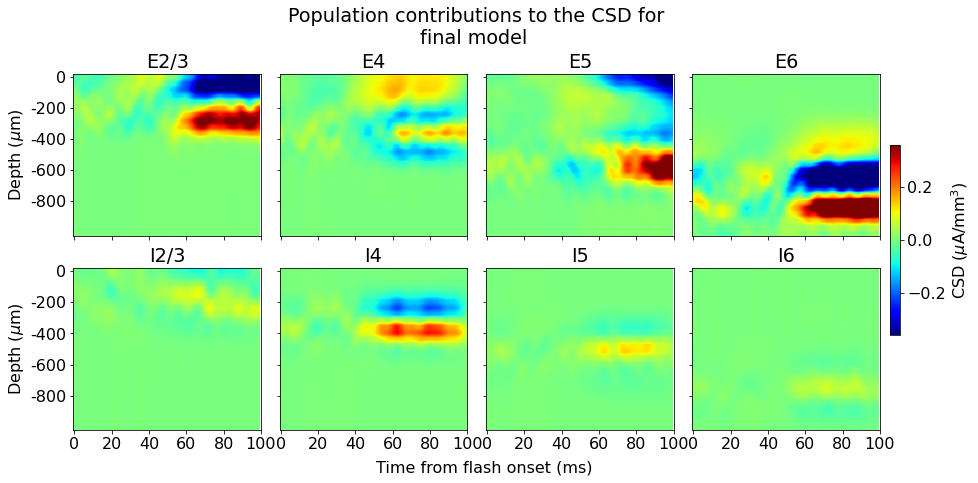

In [25]:
scale_to_uA = 1E-3

for sim_name, csd_sim_layerpops in sorted(csd_sims_layerpops.items()):
    #if '12' not in sim_name:
    #    continue
    
    fig, axes = plt.subplots(nrows=2,ncols=4,figsize=(14,6.6), sharex = True, sharey = True)

    fig.subplots_adjust(wspace = 0.1, left = 0.1, right = 0.9, bottom = 0.1, top = 0.85)
    ipop = 0
    for pop_name, csd_sim_layerpop in csd_sim_layerpops.items():
        if pop_name == '1i':
            continue
        irow = ipop // 4
        icol = ipop % 4
        csd_sim_layerpop_trial_avg = np.mean(csd_sim_layerpop, axis = 0)*scale_to_uA
        csd_plot = csd_sim_layerpop_trial_avg[:, tstim_onset_sim:tstim_onset_sim+100]
        
        im = axes[irow,icol].imshow(csd_plot, cmap = 'jet', aspect = 'auto', vmin = -cmap_range, vmax = cmap_range)
        
        axes[irow,icol].set_title(pop_name_labels[pop_name])
        
        ipop += 1     

    axes[0,0].set_yticks(depth_ticks_sim)
    axes[0,0].set_yticklabels(depth_ticklabels_sim)

    axes[0,0].set_ylabel('Depth ($\mu$m)')
    axes[1,0].set_ylabel('Depth ($\mu$m)')
    
    axes[0,0].set_xticks(time_ticks_sim)
    axes[0,0].set_xticklabels(time_ticklabels_sim)
    
    cbaxes = fig.add_axes([0.91, 0.3, 0.01, 0.4])
    cb = fig.colorbar(im, ax = axes[-1,-1], cax = cbaxes)
    cb.set_label('CSD ($\mu$A/mm$^3$)')
    
    fig.suptitle('Population contributions to the CSD for\n'+sims_labels[sim_name].lower().split('\n')[0], y = 0.99)
    
    plt.figtext(s = 'Time from flash onset (ms)', x = 0.4, y = 0.01)
    
    title = sims_labels[sim_name]
    #fig.suptitle(title, y = 0.9)
    
    fig_name = 'csd_pops_'+sim_name+'.png'
    
    savepath = os.path.join(fig_dir, fig_name)
    
    #fig.savefig(savepath, facecolor = 'w')

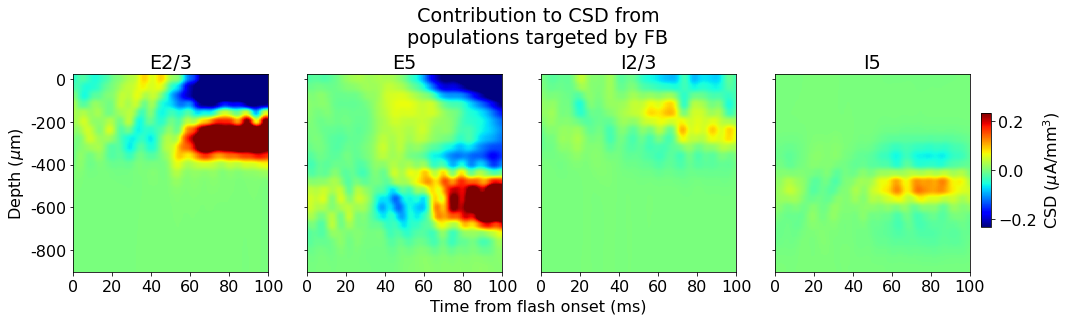

In [26]:


for sim_name, csd_sim_layerpops in sorted(csd_sims_layerpops.items()):
    #if '12' not in sim_name:
    #    continue
    
    fig, axes = plt.subplots(nrows=1,ncols=4,figsize=(15,4.5), sharex = True, sharey = True)

    fig.subplots_adjust(wspace = 0.2, hspace = 0.25, left = 0.07, right = 0.9, bottom = 0.16, top = 0.77)
    ipop = 0
    for pop_name, csd_sim_layerpop in csd_sim_layerpops.items():
        if pop_name not in ['23e', '5e', '23i', '5i']:
            continue
        icol = ipop % 4
        ax = axes[icol]
        csd_sim_layerpop_trial_avg = np.mean(csd_sim_layerpop, axis = 0)*scale_to_uA
        csd_plot = csd_sim_layerpop_trial_avg[:nchan_sim, tstim_onset_sim:tstim_onset_sim+101]
        
        if ipop == 0:
            cmap_range = np.abs(csd_plot).max()/2
        
        im = ax.imshow(csd_plot, cmap = 'jet', aspect = 'auto', vmin = -cmap_range, vmax = cmap_range)
        
        ax.set_title(pop_name_labels[pop_name])
        
        ipop += 1     

    axes[0].set_yticks(depth_ticks_sim)
    axes[0].set_yticklabels(depth_ticklabels_sim)
    
    axes[0].set_xlim([0,100])

    axes[0].set_ylabel('Depth ($\mu$m)')
    #axes[1,0].set_ylabel('Depth ($\mu$m)')
    
    axes[0].set_xticks(time_ticks_sim)
    axes[0].set_xticklabels(time_ticklabels_sim)
    
    cbaxes = fig.add_axes([0.91, 0.3, 0.01, 0.35])
    cb = fig.colorbar(im, ax = axes[-1], cax = cbaxes)
    cb.set_label('CSD ($\mu$A/mm$^3$)')
    
    plt.figtext(s = 'Time from flash onset (ms)', x = 0.4, y = 0.04)
    
    title = 'Contribution to CSD from\npopulations targeted by FB'
    fig.suptitle(title, y = 0.98)
    
    
    fig_name = 'csd_targeted_pops_'+sim_name+'.png'
    
    savepath = os.path.join(fig_dir, fig_name)
    
    fig.savefig(savepath, facecolor = 'w')

In [27]:
fig_dir

'Figures/Figure_6'

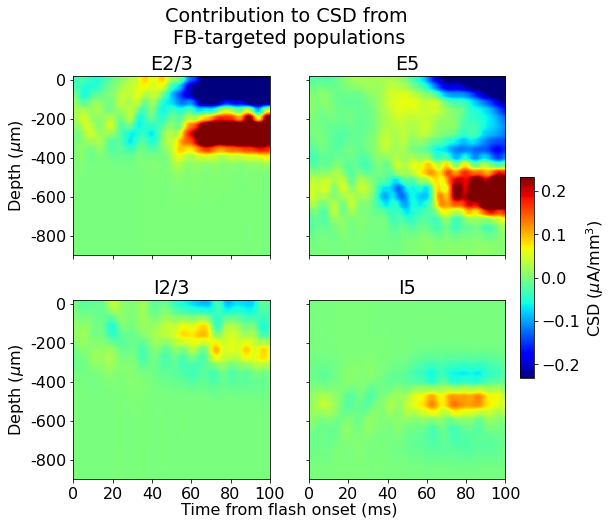

In [28]:


for sim_name, csd_sim_layerpops in sorted(csd_sims_layerpops.items()):
    #if '12' not in sim_name:
    #    continue
    
    fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(10,8), sharex = True, sharey = True)

    fig.subplots_adjust(wspace = 0.2, hspace = 0.25, left = 0.2, right = 0.8, bottom = 0.15, top = 0.85)
    ipop = 0
    for pop_name, csd_sim_layerpop in csd_sim_layerpops.items():
        if pop_name not in ['23e', '5e', '23i', '5i']:
            continue
        irow = ipop // 2
        icol = ipop % 2
        csd_sim_layerpop_trial_avg = np.mean(csd_sim_layerpop, axis = 0)*scale_to_uA
        csd_plot = csd_sim_layerpop_trial_avg[:nchan_sim, tstim_onset_sim:tstim_onset_sim+101]
        
        if ipop == 0:
            cmap_range = np.abs(csd_plot).max()/2
        
        im = axes[irow,icol].imshow(csd_plot, cmap = 'jet', aspect = 'auto', vmin = -cmap_range, vmax = cmap_range)
        
        axes[irow,icol].set_title(pop_name_labels[pop_name])
        
        ipop += 1     

    axes[0,0].set_yticks(depth_ticks_sim)
    axes[0,0].set_yticklabels(depth_ticklabels_sim)
    
    axes[0,0].set_xlim([0,100])

    axes[0,0].set_ylabel('Depth ($\mu$m)')
    axes[1,0].set_ylabel('Depth ($\mu$m)')
    
    axes[0,0].set_xticks(time_ticks_sim)
    axes[0,0].set_xticklabels(time_ticklabels_sim)
    
    cbaxes = fig.add_axes([0.82, 0.325, 0.02, 0.35])
    cb = fig.colorbar(im, ax = axes[-1,-1], cax = cbaxes)
    cb.set_label('CSD ($\mu$A/mm$^3$)')
    
    plt.figtext(s = 'Time from flash onset (ms)', x = 0.35, y = 0.09)
    
    title = 'Contribution to CSD from \nFB-targeted populations'
    fig.suptitle(title, y = 0.97)
    
    
    fig_name = 'csd_targeted_pops_'+sim_name+'.png'
    
    savepath = os.path.join(fig_dir, fig_name)
    
    #fig.savefig(savepath, facecolor = 'w')

### Spikes

In [29]:
sims_spike_trains_cell_pops = dict()

In [30]:

for sim_name in sorted(list(timestamps_configs.keys())):
    print(sim_name)

    timestamps_all_cell_pops = timestamps_configs[sim_name]
    cell_names = list(timestamps_all_cell_pops.keys())


    sim_spike_trains_cell_pops = dict()

    for cell_name in cell_names:
        print(cell_name)
        timestamps_cell_pop = timestamps_all_cell_pops[cell_name]

        neuron_ids = timestamps_cell_pop['neuron_ids_of_timestamps']
        trials = timestamps_cell_pop['trials']
        timestamps = timestamps_cell_pop['timestamps']
        #timestamps = timestamps_cell_pop['timestamps_by_trial']
        trial_dur_sim = timestamps_cell_pop['trial_dur']
        #ntrials_sim = len(np.unique(trials))
        '''TODO: Implement general way to determine # of trials (that also works for sims that lasted a bit too long)'''
        ntrials_sim = 10
        timestamps = timestamps % trial_dur_sim
        all_neuron_ids = timestamps_cell_pop['all_neuron_ids_in_pop']

        spike_trains = np.zeros((len(all_neuron_ids), ntrials_sim, trial_dur_sim))
        bins = np.arange(0,trial_dur_sim+1,1)

        for i_nrn, neuron_id in enumerate(all_neuron_ids):
            mask_neuron_id = neuron_ids == neuron_id

            timestamps_nrn = timestamps[mask_neuron_id]

            trials_this_nrn = trials[mask_neuron_id]

            for trial in np.unique(trials_this_nrn):
                if trial >= ntrials_sim:
                    continue
                mask_trial = trials_this_nrn == trial
                timestamps_nrn_this_trial = timestamps_nrn[mask_trial]
                spike_train_trial, _ = np.histogram(timestamps_nrn_this_trial, bins)

                spike_trains[i_nrn, int(trial)] = spike_train_trial

        sim_spike_trains_cell_pops[cell_name] = spike_trains[:,:ntrials_sim]
        
    sims_spike_trains_cell_pops[sim_name] = sim_spike_trains_cell_pops

final_model
e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
i23Htr3a
i23Pvalb
i23Sst
i4Htr3a
i4Pvalb
i4Sst
i5Htr3a
i5Pvalb
i5Sst
i6Htr3a
i6Pvalb
i6Sst
intermediate_model
e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
i23Htr3a
i23Pvalb
i23Sst
i4Htr3a
i4Pvalb
i4Sst
i5Htr3a
i5Pvalb
i5Sst
i6Htr3a
i6Pvalb
i6Sst
old_model
e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
i23Htr3a
i23Pvalb
i23Sst
i4Htr3a
i4Pvalb
i4Sst
i5Htr3a
i5Pvalb
i5Sst
i6Htr3a
i6Pvalb
i6Sst


In [31]:
sims_spike_trains_layer_pops = dict()

for sim_name in sims_spike_trains_cell_pops.keys():

    sim_spike_trains_layer_pops = dict()

    sim_spike_trains_layer_pops['RS L2/3'] = []
    sim_spike_trains_layer_pops['RS L4'] = []
    sim_spike_trains_layer_pops['RS L5'] = []
    sim_spike_trains_layer_pops['RS L6'] = []
    sim_spike_trains_layer_pops['FS'] = []

    for cell_pop_name, sim_spike_trains_cell_pop in sims_spike_trains_cell_pops[sim_name].items():
        print(cell_pop_name)#, sim_spike_trains_cell_pops[cell_pop_name].shape)
        #if cell_pop_name[0] == 'e' and cell_pop_name[1] == '2':
        if cell_pop_name[-5:] != 'Pvalb' and cell_pop_name[1] == '2':
            if len(sim_spike_trains_layer_pops['RS L2/3']) == 0:
                sim_spike_trains_layer_pops['RS L2/3'] = sim_spike_trains_cell_pop
            else:
                sim_spike_trains_layer_pops['RS L2/3'] = np.concatenate((sim_spike_trains_layer_pops['RS L2/3'], 
                                                               sim_spike_trains_cell_pop), axis = 0)

        #elif cell_pop_name[0] == 'e' and cell_pop_name[1] == '4':
        elif cell_pop_name[-5:] != 'Pvalb' and cell_pop_name[1] == '4':
            if len(sim_spike_trains_layer_pops['RS L4']) == 0:
                sim_spike_trains_layer_pops['RS L4'] = sim_spike_trains_cell_pop
            else:
                sim_spike_trains_layer_pops['RS L4'] = np.concatenate((sim_spike_trains_layer_pops['RS L4'], 
                                                               sim_spike_trains_cell_pop), axis = 0)

        elif cell_pop_name[-5:] != 'Pvalb' and cell_pop_name[1] == '5':
            if len(sim_spike_trains_layer_pops['RS L5']) == 0:
                sim_spike_trains_layer_pops['RS L5'] = sim_spike_trains_cell_pop
            else:
                sim_spike_trains_layer_pops['RS L5'] = np.concatenate((sim_spike_trains_layer_pops['RS L5'], 
                                                               sim_spike_trains_cell_pop), axis = 0)

        elif cell_pop_name[-5:] != 'Pvalb' and cell_pop_name[1] == '6':
            if len(sim_spike_trains_layer_pops['RS L6']) == 0:
                sim_spike_trains_layer_pops['RS L6'] = sim_spike_trains_cell_pop
            else:
                sim_spike_trains_layer_pops['RS L6'] = np.concatenate((sim_spike_trains_layer_pops['RS L6'], 
                                                               sim_spike_trains_cell_pop), axis = 0)

        elif cell_pop_name[-5:] == 'Pvalb':
            if len(sim_spike_trains_layer_pops['FS']) == 0:
                sim_spike_trains_layer_pops['FS'] = sim_spike_trains_cell_pop
            else:
                sim_spike_trains_layer_pops['FS'] = np.concatenate((sim_spike_trains_layer_pops['FS'], 
                                                               sim_spike_trains_cell_pop), axis = 0)
                
                
    sims_spike_trains_layer_pops[sim_name] = sim_spike_trains_layer_pops

e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
i23Htr3a
i23Pvalb
i23Sst
i4Htr3a
i4Pvalb
i4Sst
i5Htr3a
i5Pvalb
i5Sst
i6Htr3a
i6Pvalb
i6Sst
e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
i23Htr3a
i23Pvalb
i23Sst
i4Htr3a
i4Pvalb
i4Sst
i5Htr3a
i5Pvalb
i5Sst
i6Htr3a
i6Pvalb
i6Sst
e23Cux2
e4Nr5a1
e4Rorb
e4Scnn1a
e4other
e5Rbp4
e5noRbp4
e6Ntsr1
i1Htr3a
i23Htr3a
i23Pvalb
i23Sst
i4Htr3a
i4Pvalb
i4Sst
i5Htr3a
i5Pvalb
i5Sst
i6Htr3a
i6Pvalb
i6Sst


### Plot firing rates

In [32]:
loadpaths_unit_depths = sorted(glob(os.path.join(exp_meta_data_dir, 'units_cortical_depth', '*')))

In [33]:

sessions_units_depth = dict()


for file_path in loadpaths_unit_depths:
    properties = dict()
    
    session_id = file_path.split('/')[-1].split('_')[-1].split('.')[0]
    units_depth = pd.read_csv(file_path, sep=' ')
    units_depth = units_depth.set_index('id')
    
    properties['layer'] = units_depth['cortical_layer']
    properties['depth'] = units_depth['cortical_depth']
    
    sessions_units_depth[session_id] = properties

#### Split into layers (but merge inhibitory cells)

In [34]:
sessions_spike_trains_layer_pops = dict()
#for session_id in sessions_units_dist_top_channel.keys():
for session_id, units_depth in sessions_units_depth.items():
    #units_dist_top_channel = sessions_units_dist_top_channel[session_id]
    session_id = int(session_id)
    
    spike_trains_E23 = []
    spike_trains_E4 = []
    spike_trains_E5 = []
    spike_trains_E6 = []
    
    spike_trains_I = []
    
    
    if session_id in sessions_spike_trains_V1.keys():
        for unit_type in sessions_spike_trains_V1[session_id].keys():
            spike_trains = sessions_spike_trains_V1[session_id][unit_type]

            for i_unit, unit_id in enumerate(spike_trains.unit_id.values):
                spike_train = spike_trains[:,:,i_unit]
                #unit_dist_top_channel = units_dist_top_channel[unit_id]
                layer_label = units_depth['layer'][unit_id]

                if layer_label == 2:
                    # L23
                    if unit_type == 'exc':
                        spike_trains_E23.append(spike_train.values)
                elif layer_label == 4:
                    if unit_type == 'exc':
                        spike_trains_E4.append(spike_train.values)
                elif layer_label == 5:
                    if unit_type == 'exc':
                        spike_trains_E5.append(spike_train.values)
                elif layer_label == 6:
                    if unit_type == 'exc':
                        spike_trains_E6.append(spike_train.values)
                        
                if unit_type == 'inh':
                    spike_trains_I.append(spike_train.values)

        spike_trains_layer_pops = dict()

        spike_trains_layer_pops['RS L2/3'] = np.array(spike_trains_E23)
        spike_trains_layer_pops['RS L4'] = np.array(spike_trains_E4)
        spike_trains_layer_pops['RS L5'] = np.array(spike_trains_E5)
        spike_trains_layer_pops['RS L6'] = np.array(spike_trains_E6)
        spike_trains_layer_pops['FS'] = np.array(spike_trains_I)

        sessions_spike_trains_layer_pops[session_id] = spike_trains_layer_pops
        

In [35]:
all_spike_trains_layer_pops = dict()

all_spike_trains_layer_pops['RS L2/3'] = []
all_spike_trains_layer_pops['RS L4'] = []
all_spike_trains_layer_pops['RS L5'] = []
all_spike_trains_layer_pops['RS L6'] = []
all_spike_trains_layer_pops['FS'] = []

sessions_ncells_layer_pops = dict()

for session_id, spike_trains_layer_pops in sessions_spike_trains_layer_pops.items():
    ncells_layer_pops = dict()
    for pop_name, spike_trains in spike_trains_layer_pops.items():
        
        ncells_layer_pops[pop_name] = len(spike_trains)
        
        if len(spike_trains) == 0:
            continue
        elif len(all_spike_trains_layer_pops[pop_name]) == 0:
            print(pop_name)
            all_spike_trains_layer_pops[pop_name] = spike_trains
        else:
            all_spike_trains_layer_pops[pop_name] = np.concatenate([all_spike_trains_layer_pops[pop_name], \
                                                                   spike_trains])
            
    sessions_ncells_layer_pops[session_id] = ncells_layer_pops

RS L2/3
RS L4
RS L5
RS L6
FS


old_model


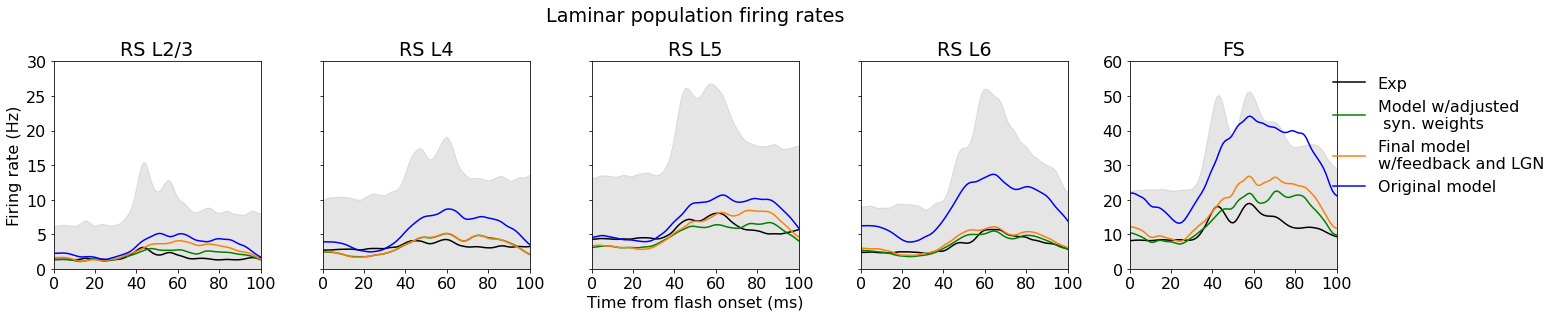

In [36]:
tstim_onset = 1000

fig, axes = plt.subplots(ncols = 5, figsize = (22,4.5))

fig.subplots_adjust(wspace = 0.3, left = 0.04, right = 0.85, bottom = 0.18, top = 0.82)

sim_names = list(sims_spike_trains_layer_pops.keys())
sim_names.insert(0, sim_names.pop())

iplot = 0
for pop_name, all_spike_trains_pop in all_spike_trains_layer_pops.items():
    
    if iplot == 4:
        axes[iplot].set_ylim([0, 60])
    else:
        axes[iplot].set_ylim([0, 30])
        if iplot == 0:
            
            fir_rate_label = 'Exp'
            std_label = '±1$\sigma$'
            
            axes[iplot].set_yticks(np.arange(0,30+5,5))
            axes[iplot].set_yticklabels(np.arange(0,30+5,5))
        else:
            fir_rate_label = None
            std_label = None
            sim_labels = [None, None]
            axes[iplot].set_yticks(np.arange(0,30+5,5))
            axes[iplot].set_yticklabels([])
    
    pop_fir_rate = np.mean(np.mean(all_spike_trains_pop, axis = 0), axis = 0) * 1E3
    
    #all_spike_trains_pop_rs = all_spike_trains_pop.reshape(all_spike_trains_pop.shape[0]*\
    #                                                       all_spike_trains_pop.shape[1],-1)
    
    fir_rate_trial_avg = np.mean(all_spike_trains_pop, axis = 1)
    
    #std_time_resolved =  np.std(all_spike_trains_pop_rs, axis = 0)[tstim_onset:tstim_onset+100]*1E3
    
    std_of_trial_avg =  np.std(fir_rate_trial_avg, axis = 0)[tstim_onset:tstim_onset+105]*1E3
    
    std_of_trial_avg = gaussian_filter(std_of_trial_avg, sigma = 2)

    
    
    fir_rate_plot = gaussian_filter(pop_fir_rate, sigma = 2)[tstim_onset:tstim_onset+105]
    
    time = np.arange(0, 105, 1)
    
    axes[iplot].plot(time, fir_rate_plot, color = 'k', label = fir_rate_label)
    
    axes[iplot].fill_between(x = time, y1 = fir_rate_plot-std_of_trial_avg, \
                             y2 = fir_rate_plot+std_of_trial_avg, color = (0.5,0.5,0.5), 
                             alpha = 0.2)
    
    for isim, sim_name in enumerate(sim_names[::-1]):
        
        sim_spike_trains_layer_pop = sims_spike_trains_layer_pops[sim_name][pop_name]

        sim_pop_fir_rate = np.mean(np.mean(sim_spike_trains_layer_pop[:, :10, \
                                    tstim_onset_sim:tstim_onset_sim+105], axis = 0), axis = 0)*1E3

        sim_fir_rate_plot = gaussian_filter(sim_pop_fir_rate, sigma = 2)

        if iplot == 0:
            sim_label = sims_labels[sim_name]
            #sim_label = sim_name
        else:
            sim_label = None
        
        axes[iplot].plot(time, sim_fir_rate_plot, color = sims_colors[sim_name], label = sim_label)
        #axes[iplot].plot(time, sim_fir_rate_plot, label = sim_label)

    
    
            
    axes[iplot].set_xticks(np.arange(0,100+20,20))
    axes[iplot].set_xticklabels(np.arange(0,100+20,20))
    
    axes[iplot].set_xlim([0,100])
    
    axes[iplot].set_title(pop_name)
    iplot += 1
    
axes[0].set_ylabel('Firing rate (Hz)')

fig.suptitle('Laminar population firing rates', y = 0.99, x = 0.445)
    
#plt.figtext(s = 'Time from flash onset (ms)', x = 0.43, y = 0.05)
axes[2].set_xlabel('Time from flash onset (ms)')
    
fig.legend(bbox_to_anchor = (0.99, 0.82), frameon = False)
print(sim_name)
fig_name = 'exp_and_sim_pop_fir_rate_'+sim_name+'.png'

savepath = os.path.join('Figures', 'Figure_6', fig_name)

#fig.savefig(savepath, facecolor = 'w')

### KS-similarity

- KS-similarity between distribution of firing rates across cells in simulations and distribution of firing rates across cells from all animals.
- Note: You can load the pre-computed KS-similarities for all animals in cell below. If you are interested in how the KS-similarity is calculated, go to the notebook titled "Figure_2_and_3"

### Load data

In [37]:
filename = 'exp_ks_simil_mode_w-RS-FS-naming.npy'
loadpath = os.path.join(exp_data_dir, 'spikes', 'V1', 'KS-similarity', filename)

sessions_mode_ks_simil = np.load(loadpath, allow_pickle = True)[()]

In [38]:
mode_ks_simil_all = dict()

for mode, sessions_ks_simil in sessions_mode_ks_simil.items():
    ks_simil_all = dict()
    ks_simil_all['RS L2/3'] = []
    ks_simil_all['RS L4'] = []
    ks_simil_all['RS L5'] = []
    ks_simil_all['RS L6'] = []
    ks_simil_all['FS'] = []

    for session_id, ks_simil_pops in sessions_ks_simil.items():

        for pop_name, ks_simil in ks_simil_pops.items():
            if ks_simil == -1:
                continue
            elif pop_name == 'E23':
                pop_name = 'E2/3'

            ks_simil_all[pop_name].append(ks_simil)
            
    mode_ks_simil_all[mode] = ks_simil_all

### KS-similarity between model and experiments

In [39]:
sims_ks_simil_modes = dict()

for sim_name, sim_spike_trains_layer_pops in sims_spike_trains_layer_pops.items():
    print(sim_name)

    sim_ks_simil_modes = dict()

    for mode in ['peak', 'baseline', 'post-peak']:

        #print(mode)

        if mode == 'peak':
            t_start_exp = tstim_onset+35
            t_stop_exp = tstim_onset+60

            t_start_sim = tstim_onset_sim+35
            t_stop_sim = tstim_onset_sim+60
        elif mode == 'baseline':
            t_start_exp = 750
            t_stop_exp = tstim_onset

            t_start_sim = 0
            t_stop_sim = tstim_onset_sim
        elif mode == 'post-peak':
            t_start_exp = tstim_onset+60
            t_stop_exp = tstim_onset+100

            t_start_sim = tstim_onset_sim+60
            t_stop_sim = tstim_onset_sim+100

        sim_ks_simil_pop = dict()
        for pop_name, all_spike_trains_pop in all_spike_trains_layer_pops.items():
            print(pop_name, sim_spike_trains_layer_pops[pop_name].shape[0])

            exp_spike_trains_pop = all_spike_trains_pop[:,:,t_start_exp:t_stop_exp]

            sim_spike_trains_layer_pop = sim_spike_trains_layer_pops[pop_name][:,:ntrials_sim,t_start_sim:t_stop_sim]

            sim_fir_rate = np.mean(np.mean(sim_spike_trains_layer_pop, axis = -1), axis = -1)

            exp_fir_rate = np.mean(np.mean(exp_spike_trains_pop, axis = -1), axis = -1)

            ks_dist = stats.ks_2samp(exp_fir_rate, sim_fir_rate)[0]

            ks_simil_temp = 1-ks_dist

            sim_ks_simil_pop[pop_name] = ks_simil_temp

        sim_ks_simil_modes[mode] = sim_ks_simil_pop
        
    sims_ks_simil_modes[sim_name] = sim_ks_simil_modes

final_model
RS L2/3 14260
RS L4 11077
RS L5 8241
RS L6 14133
FS 3268
RS L2/3 14260
RS L4 11077
RS L5 8241
RS L6 14133
FS 3268
RS L2/3 14260
RS L4 11077
RS L5 8241
RS L6 14133
FS 3268
intermediate_model
RS L2/3 14260
RS L4 11077
RS L5 8241
RS L6 14133
FS 3268
RS L2/3 14260
RS L4 11077
RS L5 8241
RS L6 14133
FS 3268
RS L2/3 14260
RS L4 11077
RS L5 8241
RS L6 14133
FS 3268
old_model
RS L2/3 14260
RS L4 11077
RS L5 8241
RS L6 14133
FS 3268
RS L2/3 14260
RS L4 11077
RS L5 8241
RS L6 14133
FS 3268
RS L2/3 14260
RS L4 11077
RS L5 8241
RS L6 14133
FS 3268


In [40]:
for sim_name, ks_simil_modes in sims_ks_simil_modes.items():
    for mode, ks_simil in ks_simil_modes.items():
        print(sim_name, mode, np.round(np.mean(np.array(list(ks_simil.values()))), 2))

final_model peak 0.7
final_model baseline 0.77
final_model post-peak 0.68
intermediate_model peak 0.73
intermediate_model baseline 0.79
intermediate_model post-peak 0.7
old_model peak 0.6
old_model baseline 0.67
old_model post-peak 0.58


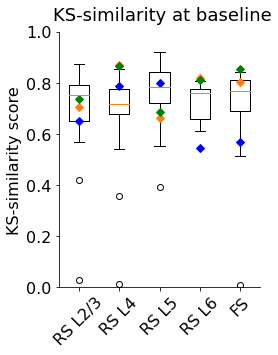

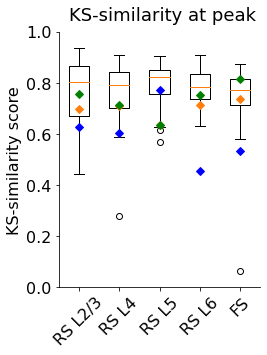

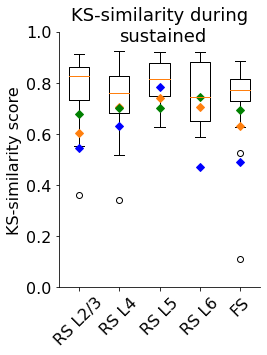

In [41]:
for mode in ['baseline', 'peak', 'post-peak']:

    fig, ax = plt.subplots(ncols = 1, figsize = (4,5), sharey = True)

    fig.subplots_adjust(wspace = 0.3, left = 0.22, right = 0.92, bottom = 0.2, top = 0.91)

    ks_simil_all = mode_ks_simil_all[mode]

    ipop = 0
    for pop_name, ks_simil_pop in ks_simil_all.items():
        ax.boxplot(ks_simil_pop, positions = [0.3*ipop])

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        for sim_name, sim_ks_simil_modes in sorted(sims_ks_simil_modes.items()):

            #if '24' in sim_name:
            #    continue

            sim_ks_simil_pop = sim_ks_simil_modes[mode][pop_name]

            if ipop == 0:
                sim_label = sims_labels[sim_name]
                #sim_label = sim_name
            else:
                sim_label = None

            ax.plot(0.3*ipop, sim_ks_simil_pop, 'D', color = sims_colors[sim_name], label = sim_label)

        ipop += 1


    ax.set_xticklabels(list(ks_simil_all.keys()), rotation = 45)

    #fig.legend()

    ax.set_ylim([0.0, 1])
    ax.set_xlim([0-0.3/2,0.3*(ipop-1/2)])
    ax.set_ylabel('KS-similarity score')

    if mode == 'baseline':
        mode_title = 'at baseline'
    elif mode == 'peak':
        mode_title = 'at peak'
    elif mode == 'post-peak':
        mode_title = 'during \nsustained'

    fig.suptitle('KS-similarity '+mode_title, x = 0.58, y = 0.98, fontsize = 18)

    #fig.legend(bbox_to_anchor = (1.5,0.9))

    fig_name = 'KS-similarity-at-'+mode+'-'+sim_name+'.png'
    #savepath = os.path.join('Figures', 'Supplementary_figures', fig_name)
    savepath = os.path.join(fig_dir, fig_name)


    #fig.savefig(savepath, facecolor = 'w')

## Correlation

- Correlation between trial-averaged population firing rates
- Note: You can load the pre-computed correlation for all animals in cells further below. You can go to the notebook titled "Figure_2_and_3" to see how the calculation is done.

### Load data

In [42]:
filename = 'exp_corr_fir_rate-w-RS-FS-naming.npy'
loadpath = os.path.join(exp_data_dir, 'spikes', 'V1', 'correlation', filename)

sessions_corr_fir_rate = np.load(loadpath, allow_pickle = True)[()]

In [43]:
corr_fir_rates_all = dict()
corr_fir_rates_all['RS L2/3'] = []
corr_fir_rates_all['RS L4'] = []
corr_fir_rates_all['RS L5'] = []
corr_fir_rates_all['RS L6'] = []
corr_fir_rates_all['FS'] = []

for session_id, corr_fir_rate_pops in sessions_corr_fir_rate.items():

    for pop_name, corr_fir_rates in corr_fir_rate_pops.items():
        if corr_fir_rates == -1:
            continue
        elif pop_name == 'E23':
            pop_name = 'E2/3'

        corr_fir_rates_all[pop_name].append(corr_fir_rates)

### Correlation between sim and exp trial avg firing rate

In [44]:
t_start_exp = tstim_onset
t_stop_exp = tstim_onset+100

t_start_sim = tstim_onset_sim
t_stop_sim = tstim_onset_sim+100

sims_corr_pop_fir_rates = dict()
for sim_name, sim_spike_trains_layer_pops in sims_spike_trains_layer_pops.items():
    sim_corr_pop_fir_rates = dict()
    for pop_name, all_spike_trains_pop in all_spike_trains_layer_pops.items():
        print(pop_name)

        exp_spike_trains_pop = all_spike_trains_pop[:,:,t_start_exp:t_stop_exp]

        sim_spike_trains_layer_pop = sim_spike_trains_layer_pops[pop_name][:,:ntrials_sim,t_start_sim:t_stop_sim]

        sim_fir_rate = np.mean(np.mean(sim_spike_trains_layer_pop, axis = 0), axis = 0)

        exp_fir_rate = np.mean(np.mean(exp_spike_trains_pop, axis = 0), axis = 0)

        corr, p = stats.pearsonr(exp_fir_rate, sim_fir_rate)
        
        #corr = np.dot(sim_fir_rate, exp_fir_rate) / (np.linalg.norm(sim_fir_rate)*np.linalg.norm(exp_fir_rate))

        print(sim_name, pop_name, 'r = ', np.round(corr, 2), 'p =', np.round(p,4))
        
        sim_corr_pop_fir_rates[pop_name] = corr
        
    sims_corr_pop_fir_rates[sim_name] = sim_corr_pop_fir_rates

RS L2/3
final_model RS L2/3 r =  0.36 p = 0.0003
RS L4
final_model RS L4 r =  0.64 p = 0.0
RS L5
final_model RS L5 r =  0.69 p = 0.0
RS L6
final_model RS L6 r =  0.87 p = 0.0
FS
final_model FS r =  0.77 p = 0.0
RS L2/3
intermediate_model RS L2/3 r =  0.49 p = 0.0
RS L4
intermediate_model RS L4 r =  0.63 p = 0.0
RS L5
intermediate_model RS L5 r =  0.71 p = 0.0
RS L6
intermediate_model RS L6 r =  0.87 p = 0.0
FS
intermediate_model FS r =  0.76 p = 0.0
RS L2/3
old_model RS L2/3 r =  0.38 p = 0.0001
RS L4
old_model RS L4 r =  0.62 p = 0.0
RS L5
old_model RS L5 r =  0.76 p = 0.0
RS L6
old_model RS L6 r =  0.89 p = 0.0
FS
old_model FS r =  0.8 p = 0.0


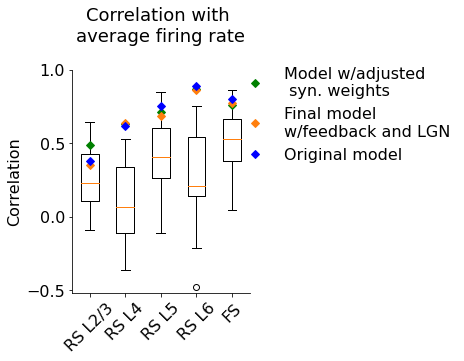

In [45]:
fig, ax = plt.subplots(ncols = 1, figsize = (6.5,5), sharey = True)

fig.subplots_adjust(left = 0.16, right = 0.54, bottom = 0.18, top = 0.8)

ipop = 0
for pop_name, corr_fir_rate_pop in corr_fir_rates_all.items():
    ax.boxplot(corr_fir_rate_pop, positions = [0.3*ipop])
        
    for sim_name in sim_names[::-1]:
        
        sim_corr_pop_fir_rates = sims_corr_pop_fir_rates[sim_name]
        
        if ipop == 0:
            sim_label = sims_labels[sim_name]
        else:
            sim_label = None
            
        ax.plot(0.3*ipop, sim_corr_pop_fir_rates[pop_name], 'D', color = sims_colors[sim_name], label = sim_label)

    ipop+=1

    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylim([-.52, 1])
ax.set_ylabel('Correlation')

ax.set_title('Correlation with \naverage firing rate', x = 0.5, y = 1.1, fontsize = 18)


ax.set_xlim([0-0.3/2,0.3*(ipop-1/2)])
ax.set_xticklabels(list(corr_fir_rates_all.keys()), rotation = 45)

fig.legend(bbox_to_anchor = (1.0, 0.85), frameon=False)
    
fig_name = 'correlation-0-100ms-'+sim_name+'.png'
savepath = os.path.join(fig_dir, fig_name)

#fig.savefig(savepath, facecolor = 'w')

### LFP and CSD

In [46]:

#filename = 'cortical_depth_'+str(session_id)+'.csv'
#loadpath = os.path.join(exp_meta_data_dir, 'probes_cortical_depths', filename)
sessions_df_depth = dict()
loadpaths = sorted(glob(os.path.join(exp_meta_data_dir, 'probes_cortical_depths', '*')))
for loadpath in loadpaths:
    session_id = loadpath.split('/')[-1].split('.')[0].split('_')[-1]
    df_depth = pd.read_csv(loadpath, sep=' ')
    df_depth = df_depth.set_index('id')
    sessions_df_depth[session_id] = df_depth


In [47]:
session_id = list(sessions_df_depth.keys())[1]

channel_step_exp = 5
depth_ticks_exp = np.arange(0, len(channels_vert_pos), channel_step_exp)
depth_step_exp = channel_step_exp*np.diff(channels_vert_pos)[0]
depth_ticklabels_exp = np.arange(channels_vert_pos[0], channels_vert_pos[-1]+depth_step_exp, depth_step_exp) 


time_start_label_exp = 0
time_stop_label_exp = 100
time_step_label_exp = 20
time_ticklabels_exp = np.arange(time_start_label_exp, time_stop_label_exp+time_step_label_exp, time_step_label_exp)
sf = 1250
time_tick_step_exp = int(time_step_label_exp*sf/1E3)
time_ticks_exp = np.arange(0, sessions_csd_trial_avg[session_id].shape[-1]+time_tick_step_exp, time_tick_step_exp)

## PCA on trial averaged CSD

### Interpolate and normalize

#### Exp

In [48]:
sessions_csd_trial_avg_interp = dict()
sessions_sinks_trial_avg_interp = dict()
sessions_sources_trial_avg_interp = dict()

sp_len = 30; t_len = 100
for i_sess, session_id in enumerate(sessions_csd_trial_avg_short.keys()):
    csd_trial_avg = sessions_csd_trial_avg_short[session_id]
    
    sinks_interp = np.zeros((sp_len, t_len))
    sources_interp = np.zeros((sp_len, t_len))
    
    z = csd_trial_avg
    x = np.linspace(0., 1., z.shape[1], endpoint=True)
    y = np.linspace(0., 1., z.shape[0], endpoint=True)
    #xx, yy = np.meshgrid(x, y)
    f = interpolate.interp2d(x, y, z, kind='cubic')

    x_new = np.linspace(0., 1., t_len, endpoint=True)
    y_new = np.linspace(0., 1., sp_len, endpoint=True)
    csd_interp = f(x_new, y_new)
    
    mask_sinks = csd_interp < 0
    mask_sources = csd_interp > 0
    
    sinks_interp[mask_sinks] = np.abs(csd_interp[mask_sinks])
    sources_interp[mask_sources] = np.abs(csd_interp[mask_sources])
    
    
    sessions_csd_trial_avg_interp[session_id] = csd_interp/np.abs(csd_interp).max()
    sessions_sinks_trial_avg_interp[session_id] = sinks_interp/sinks_interp.sum()
    sessions_sources_trial_avg_interp[session_id] = sources_interp/sources_interp.sum()

### Doing the PCA

In [49]:
csd_trial_avg_interp_grand = np.array(list(sessions_csd_trial_avg_interp.values()))
csd_trial_avg_interp_grand = csd_trial_avg_interp_grand.reshape(csd_trial_avg_interp_grand.shape[0], 
                        csd_trial_avg_interp_grand.shape[1]*csd_trial_avg_interp_grand.shape[2])

n_components = csd_trial_avg_interp_grand.shape[0]
pca = PCA(n_components=n_components)

pca.fit(csd_trial_avg_interp_grand.T)

PCA(n_components=44)

In [50]:
print(pca.explained_variance_ratio_)

[5.03910403e-01 1.38802335e-01 6.61447376e-02 5.30769109e-02
 3.32573348e-02 2.73709661e-02 2.26092151e-02 2.01221678e-02
 1.61550654e-02 1.30111692e-02 1.20868404e-02 1.03926962e-02
 9.41570153e-03 9.14499572e-03 6.42395357e-03 5.56246257e-03
 5.29747046e-03 4.34798311e-03 4.01254791e-03 3.89161973e-03
 3.56123120e-03 3.07196030e-03 2.93426248e-03 2.76032325e-03
 2.34272899e-03 2.23431932e-03 1.97779675e-03 1.81658373e-03
 1.61282564e-03 1.44059109e-03 1.35826902e-03 1.30787127e-03
 1.15977315e-03 1.09017860e-03 9.22867875e-04 8.02214636e-04
 7.85934912e-04 7.20523152e-04 6.29956384e-04 5.91210127e-04
 5.30757358e-04 4.64248098e-04 4.43407897e-04 4.03589006e-04]


#### Reshape components into CSD shape with (space, time) interpolated dimensions

In [51]:
# Look at first four components
recon = np.empty((4, sp_len, t_len))
for compNr in range(4):
    recon[compNr] = np.dot(pca.components_[compNr], csd_trial_avg_interp_grand).reshape(sp_len, t_len)*\
                        pca.explained_variance_ratio_[compNr]

### Split sources and sinks and do wasserstein distance calculation from trial-averaged CSD in individual animals to PC 1 CSD

In [52]:
recon_sinks_list = np.empty_like(recon)
recon_sources_list = np.empty_like(recon)

for compNr in range(recon.shape[0]):
    recon_temp = recon[compNr]
    mask_sinks = recon_temp < 0
    mask_sources = recon_temp > 0
    
    sinks_recon_temp = np.zeros_like(recon_temp)
    sinks_recon_temp[mask_sinks] = np.abs(recon_temp[mask_sinks])
    sources_recon_temp = np.zeros_like(recon_temp)
    sources_recon_temp[mask_sources] = np.abs(recon_temp[mask_sources])
    
    recon_sinks_list[compNr] = sinks_recon_temp/sinks_recon_temp.sum()
    recon_sources_list[compNr] = sources_recon_temp/sources_recon_temp.sum()

In [53]:
sinks_mice = np.array(list(sessions_sinks_trial_avg_interp.values()))
sources_mice = np.array(list(sessions_sources_trial_avg_interp.values()))

In [54]:
n_animals = len(sinks_mice)
# for sinks
compNr = 0 # selecting PC 1 component
sink_matrix_recon_exp, M_sink_recon_exp, G0_sink_recon_exp, x_s, x_t = compute_dist_matrix_exp(sinks_mice[:n_animals], 
                                                                             recon_sinks_list[compNr:compNr+1],
                                                                            mode = 'exp_to_reco')

# for sources
source_matrix_recon_exp, M_source_recon_exp, G0_source_recon_exp, x_s, x_t = compute_dist_matrix_exp(sources_mice[:n_animals], 
                                                                             recon_sources_list[compNr:compNr+1],
                                                                            mode = 'exp_to_reco')

# sum wasserstein distances calculated for sinks and sources into one matrix of Wasserstein distances from 
# individual animals to PC 1 CSD
dist_matrix_recon_exp = sink_matrix_recon_exp+source_matrix_recon_exp

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:47<00:00,  1.09s/it]


### WD between model CSD and PC 1 CSD

#### Interpolate and normalize

In [55]:
sims_sinks = dict()
sims_sources = dict()

sims_csd_interp = dict()

n_chans_in_cortex_sim = 21
for sim_name in csd_sims.keys():
    z = csd_sims[sim_name]['trial_avg'][:n_chans_in_cortex_sim,tstim_onset_sim:tstim_onset_sim+100]
    x = np.linspace(0., 1., z.shape[1], endpoint=True)
    y = np.linspace(0., 1., z.shape[0], endpoint=True)
    #xx, yy = np.meshgrid(x, y)
    f = interpolate.interp2d(x, y, z, kind='cubic')

    x_new = np.linspace(0., 1., t_len, endpoint=True)
    y_new = np.linspace(0., 1., sp_len, endpoint=True)
    csd_interp = f(x_new, y_new)

    sims_csd_interp[sim_name] = csd_interp

    mask_sinks = csd_interp < 0
    mask_sources = csd_interp > 0

    sinks_interp = np.zeros_like(csd_interp)
    sources_interp = np.zeros_like(csd_interp)

    sinks_interp[mask_sinks] = np.abs(csd_interp[mask_sinks])
    sources_interp[mask_sources] = np.abs(csd_interp[mask_sources])

    sims_sinks[sim_name] = sinks_interp / sinks_interp.sum()
    sims_sources[sim_name] = sources_interp / sources_interp.sum()


    sims_sinks_list = np.array(list(sims_sinks.values()))
    sims_sources_list = np.array(list(sims_sources.values()))

In [56]:
compNr = 0

dist_matrix_recon_sims = dict()

for sim_name in sims_sinks.keys():
    sink_matrix_recon_sim, M_sink_recon_sim, G0_sink_recon_sim, x_s, x_t = compute_dist_matrix_exp(
                                                                                recon_sinks_list[compNr:compNr+1], 
                                                                                [sims_sinks[sim_name]],
                                                                                mode = 'sim_to_recon')
    
    source_matrix_recon_sim, M_source_recon_sim, G0_source_recon_sim, x_s, x_t = compute_dist_matrix_exp(
                                                                            recon_sources_list[compNr:compNr+1], 
                                                                            [sims_sources[sim_name]],
                                                                            mode = 'sim_to_recon')
    
    dist_matrix_recon_sims[sim_name] = sink_matrix_recon_sim + source_matrix_recon_sim
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


In [57]:
sim_names = list(dist_matrix_recon_sims.keys())

['intermediate_model', 'old_model', 'final_model']
intermediate_model
old_model
final_model


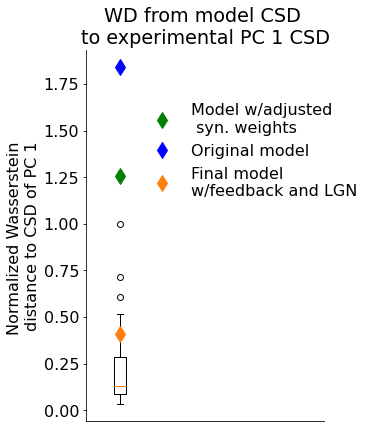

In [58]:
fig = plt.figure(figsize = (5.5,6))

ax = fig.add_subplot(1,1,1)

fig.subplots_adjust(left = 0.2, right = 0.8, bottom = 0.03, top = 0.89)

bp1 = ax.boxplot(x = dist_matrix_recon_exp[:,compNr]/dist_matrix_recon_exp[:,compNr].max(), positions = [1], widths = [0.07], patch_artist = True, \
                         boxprops=dict(facecolor="white"))


sim_names = sorted(list(dist_matrix_recon_sims.keys()))
sim_names = sim_names[1:] + [sim_names[0]]
print(sim_names)

for isim, sim_name in enumerate(sim_names):
    print(sim_name)

    ax.plot(1, dist_matrix_recon_sims[sim_name]/dist_matrix_recon_exp[:,compNr].max(), 'd', markersize = '12', color = sims_colors[sim_name], label = sims_labels[sim_name])

ax.set_xticks([])
ax.set_ylabel('Normalized Wasserstein \ndistance to CSD of PC 1')
#ax.set_ylabel('PDF')

ax.set_xlim([0.8, 2.2])

fig.legend(bbox_to_anchor = (0.92,0.8), frameon=False)

ax.set_title('WD from model CSD \nto experimental PC 1 CSD')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


#fig_name = 'smooth_pdf_WD_distr_animals_to_PC1.png'

fig_name = 'WD_distr_exp_and_sim_to_PC1_'+sim_name+'.png'

savepath = os.path.join('Figures', 'Figure_6', fig_name)

#fig.savefig(savepath, facecolor='w')